In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.inspection import permutation_importance

from features import categorical_features, skewed_features, unskewed_features, cols_idxs
from scores import save_score

In [2]:
df = pd.read_csv(os.path.join("data", "processed", "all_data2.csv"))
df.set_index("commune_id", inplace=True)
df.drop(columns=["name"], inplace=True)
vote_share_cols = [col for col in df.columns if col.startswith("vote_share_")]
df.drop(columns=vote_share_cols, inplace=True)

In [3]:
df_typo = df["typology"] # needed for stratification below

df_train, df_test = train_test_split(df, test_size=0.2, random_state=0, stratify=df_typo)
X_train = df_train.drop(columns="po_value").values
y_train = df_train["po_value"].values
X_test = df_test.drop(columns="po_value").values
y_test = df_test["po_value"].values

print("X_train.shape = {}".format(X_train.shape))
print("y_train.shape = {}".format(y_train.shape))
print("X_test.shape = {}".format(X_test.shape))
print("y_test.shape = {}".format(y_test.shape))

categorical_idxs = cols_idxs(df.drop(columns="po_value"), categorical_features)

X_train.shape = (1756, 54)
y_train.shape = (1756,)
X_test.shape = (440, 54)
y_test.shape = (440,)


In [4]:
preprocessor = make_column_transformer(
    (OneHotEncoder(dtype=np.float64), categorical_idxs),
    remainder = "passthrough"
)

gtbr = make_pipeline(preprocessor, GradientBoostingRegressor(random_state=0))
gtbr.fit(X_train, y_train)
gtbr_test_pred = gtbr.predict(X_test)
print("With default params:")
print("GTBR MAE = {:.3f}".format(mean_absolute_error(y_test, gtbr_test_pred)))
print("GTBR R^2 = {:.3f}".format(gtbr.score(X_test, y_test)))

With default params:
GTBR MAE = 0.156
GTBR R^2 = 0.742


In [5]:
parameters = {
    "gradientboostingregressor__learning_rate": [0.08, 0.09, 0.1, 0.11, 0.12 ],
    "gradientboostingregressor__n_estimators": np.linspace(100, 800, 8, dtype=int)
}
gcv_gtbr = GridSearchCV(gtbr, parameters, scoring = "neg_mean_absolute_error", cv = 5, n_jobs=12, return_train_score=True)
gcv_gtbr.fit(X_train, y_train)
print("Grid search / cross-validation:")
print("Best params = {}".format(gcv_gtbr.best_params_))
print("Best MAE = {:.3f}".format(-gcv_gtbr.best_score_))

Grid search / cross-validation:
Best params = {'gradientboostingregressor__learning_rate': 0.1, 'gradientboostingregressor__n_estimators': 700}
Best MAE = 0.153


In [6]:
gcv_gtbr_test_pred = gcv_gtbr.predict(X_test)
gcv_gtbr_test_mae = mean_absolute_error(y_test, gcv_gtbr_test_pred)
gcv_gtbr_test_r2 = r2_score(y_test, gcv_gtbr_test_pred)
print("On test data:")
print("Tuned GTBR MAE = {:.3f}".format(gcv_gtbr_test_mae))
print("Tuned GTBR R^2 = {:.3f}".format(gcv_gtbr_test_r2))

On test data:
Tuned GTBR MAE = 0.151
Tuned GTBR R^2 = 0.755


In [7]:
df_gcv_gtbr = pd.DataFrame(gcv_gtbr.cv_results_)[
    ['rank_test_score', 'mean_train_score', 'std_train_score', 'mean_test_score', 'std_test_score',
     'param_gradientboostingregressor__learning_rate', 'param_gradientboostingregressor__n_estimators']
    ].sort_values(by='rank_test_score')
df_gcv_gtbr.head()

,rank_test_score,mean_train_score,std_train_score,mean_test_score,std_test_score,param_gradientboostingregressor__learning_rate,param_gradientboostingregressor__n_estimators
22,1,-0.032000,0.000554,-0.153449,0.005468,0.1,700
23,2,-0.026568,0.000506,-0.153595,0.005657,0.1,800
21,3,-0.038796,0.000611,-0.153754,0.005010,0.1,600
7,4,-0.035799,0.000761,-0.153762,0.005917,0.08,800
6,5,-0.041778,0.000739,-0.153897,0.005776,0.08,700


In [8]:
parameters2 = {
    "gradientboostingregressor__learning_rate": [0.10],
    "gradientboostingregressor__n_estimators": [700],
    "gradientboostingregressor__max_depth": np.linspace(1, 10, 10, dtype=int),
    "gradientboostingregressor__min_samples_split": np.linspace(2, 10, 10, dtype=int)
}
gcv2_gtbr = GridSearchCV(gtbr, parameters2, scoring = "neg_mean_absolute_error", cv = 5, n_jobs=12, return_train_score=True)
gcv2_gtbr.fit(X_train, y_train)
print("Grid search / cross-validation:")
print("Best params = {}".format(gcv2_gtbr.best_params_))
print("Best MAE = {:.3f}".format(-gcv2_gtbr.best_score_))

Grid search / cross-validation:
Best params = {'gradientboostingregressor__learning_rate': 0.1, 'gradientboostingregressor__max_depth': 3, 'gradientboostingregressor__min_samples_split': 7, 'gradientboostingregressor__n_estimators': 700}
Best MAE = 0.152


In [9]:
gcv2_gtbr_test_pred = gcv2_gtbr.predict(X_test)
gcv2__gtbr_test_mae = mean_absolute_error(y_test, gcv2_gtbr_test_pred)
gcv2_gtbr_test_r2 = r2_score(y_test, gcv2_gtbr_test_pred)
print("On test data:")
print("Tuned GTBR MAE = {:.3f}".format(gcv2__gtbr_test_mae))
print("Tuned GTBR R^2 = {:.3f}".format(gcv2_gtbr_test_r2))
save_score("gtbr", gcv2__gtbr_test_mae, gcv2_gtbr_test_r2, os.path.join("data", "results", "model_scores.csv"))

On test data:
Tuned GTBR MAE = 0.153
Tuned GTBR R^2 = 0.751


In [10]:
df_gcv2_gtbr = pd.DataFrame(gcv2_gtbr.cv_results_)[
    ['rank_test_score', 'mean_train_score', 'std_train_score', 'mean_test_score', 'std_test_score',
     'param_gradientboostingregressor__learning_rate', 'param_gradientboostingregressor__n_estimators',
     'param_gradientboostingregressor__max_depth', 'param_gradientboostingregressor__min_samples_split']
    ].sort_values(by='rank_test_score')
df_gcv2_gtbr.head(5)

,rank_test_score,mean_train_score,std_train_score,mean_test_score,std_test_score,param_gradientboostingregressor__learning_rate,param_gradientboostingregressor__n_estimators,param_gradientboostingregressor__max_depth,param_gradientboostingregressor__min_samples_split
26,1,-0.032346,0.000797,-0.151973,0.005115,0.1,700,3,7
24,2,-0.031874,0.000339,-0.152479,0.005620,0.1,700,3,5
33,3,-0.008455,0.000226,-0.152484,0.004468,0.1,700,4,4
38,4,-0.009273,0.000424,-0.152774,0.004816,0.1,700,4,9
37,5,-0.008786,0.000212,-0.153052,0.004536,0.1,700,4,8


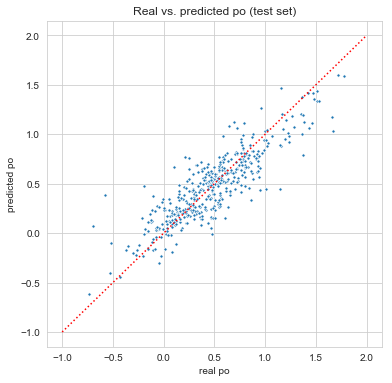

In [11]:
sns.set_style('whitegrid')
plt.figure(figsize=(6,6))
ax = sns.scatterplot(y_test, gcv2_gtbr_test_pred, s=10)
ax.set_xlabel("real po")
ax.set_ylabel("predicted po")
ax.set_title("Real vs. predicted po (test set)")
ax.plot([-1, 2], [-1, 2], color="red", linestyle=":")
plt.show()

In [12]:
sns.set_style('whitegrid')
def validationcurve_plot(title, param_range, train_scores_mean, train_scores_std, valid_scores_mean, valid_scores_std, ax):
    """Plots a validation curve and marks the best test score."""

    sns.lineplot(param_range, train_scores_mean, label="train", ax=ax)
    ax.fill_between(param_range, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.2)

    sns.lineplot(param_range, valid_scores_mean, label="validation", ax=ax)
    ax.fill_between(param_range, valid_scores_mean - valid_scores_std, valid_scores_mean + valid_scores_std, alpha=0.2)

    ax.set_title(title)
    ax.set_xlabel("n_estimators")

    best_idx = valid_scores_mean.values.argmin()
    ax.scatter(param_range[best_idx], valid_scores_mean[best_idx], marker='x', c='red', zorder=10, label="best")

    ax.legend()

In [13]:
# this is just for the charts
preprocessor = make_column_transformer(
    (OneHotEncoder(dtype=np.float64), categorical_idxs),
    remainder = "passthrough"
)
gtbr = make_pipeline(preprocessor, GradientBoostingRegressor(random_state=0))

param_range = np.append(np.linspace(10, 90, 9, dtype=int), np.linspace(100, 800, 8, dtype=int))
parameters3 = { "gradientboostingregressor__learning_rate": [0.08], "gradientboostingregressor__n_estimators": param_range,
                "gradientboostingregressor__max_depth": [3], "gradientboostingregressor__min_samples_split": [7] }
gcv3_gtbr = GridSearchCV(gtbr, parameters3, scoring = "neg_mean_absolute_error",
                         cv = 5, n_jobs=12, return_train_score=True)
gcv3_gtbr.fit(X_train, y_train)
df_gcv3_gtbr = pd.DataFrame(gcv3_gtbr.cv_results_)

parameters4 = { "gradientboostingregressor__learning_rate": [0.12], "gradientboostingregressor__n_estimators": param_range,
                "gradientboostingregressor__max_depth": [3], "gradientboostingregressor__min_samples_split": [7] }
gcv4_gtbr = GridSearchCV(gtbr, parameters4, scoring = "neg_mean_absolute_error",
                         cv = 5, n_jobs=12, return_train_score=True)
gcv4_gtbr.fit(X_train, y_train)
df_gcv4_gtbr = pd.DataFrame(gcv4_gtbr.cv_results_)

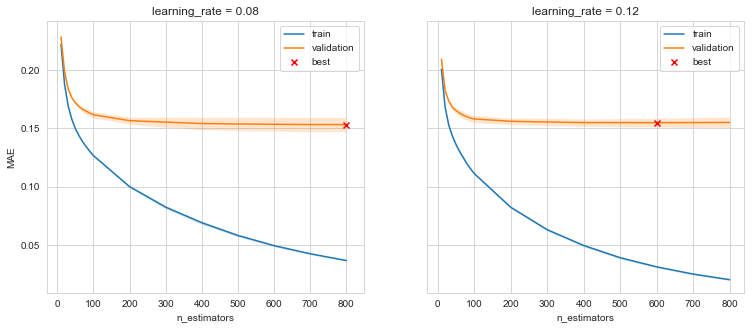

In [14]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12.5, 5), sharey=True)
validationcurve_plot("learning_rate = 0.08", param_range, -df_gcv3_gtbr["mean_train_score"], -df_gcv3_gtbr["std_train_score"],
                     -df_gcv3_gtbr["mean_test_score"], -df_gcv3_gtbr["std_test_score"], ax=ax1)
ax1.set_ylabel("MAE")
validationcurve_plot("learning_rate = 0.12", param_range, -df_gcv4_gtbr["mean_train_score"], -df_gcv4_gtbr["std_train_score"],
                     -df_gcv4_gtbr["mean_test_score"], -df_gcv4_gtbr["std_test_score"], ax=ax2)

In [15]:
print("learning rate = 0.08, MAE={:.3f}".format(-gcv3_gtbr.score(X_test, y_test)))
print("learning rate = 0.12, MAE={:.3f}".format(-gcv4_gtbr.score(X_test, y_test)))

learning rate = 0.08, MAE=0.151
learning rate = 0.12, MAE=0.155


# Feature importance

https://scikit-learn.org/stable/auto_examples/inspection/plot_permutation_importance_multicollinear.html#permutation-importance-with-multicollinear-or-correlated-features

In [16]:
preprocessor = make_column_transformer(
    (OneHotEncoder(dtype=np.float64), categorical_idxs),
    remainder = "passthrough"
)
# using best parameters from grid search above
gtbr = make_pipeline(preprocessor,
                     GradientBoostingRegressor(random_state=0, learning_rate=0.10, n_estimators=700,
                                               max_depth=3, min_samples_split=7))
gtbr.fit(X_train, y_train)
importances = permutation_importance(gtbr, X_train, y_train, scoring='neg_mean_absolute_error',
                                     n_repeats=10, n_jobs=12, random_state=0)
gtbr_test_pred = gtbr.predict(X_test)
gtbr_test_mae = mean_absolute_error(y_test, gtbr_test_pred)
gtbr_test_r2 = r2_score(y_test, gtbr_test_pred)
print("On test data:")
print("Tuned GTBR MAE = {:.3f}".format(gtbr_test_mae))
print("Tuned GTBR R^2 = {:.3f}".format(gtbr_test_r2))
print("(as above)")

On test data:
Tuned GTBR MAE = 0.153
Tuned GTBR R^2 = 0.751
(as above)


In [17]:
perm_sorted_idx = importances["importances_mean"].argsort()
importances_sorted = importances["importances_mean"][perm_sorted_idx]
cols_sorted = df_train.drop(columns="po_value").columns[perm_sorted_idx]

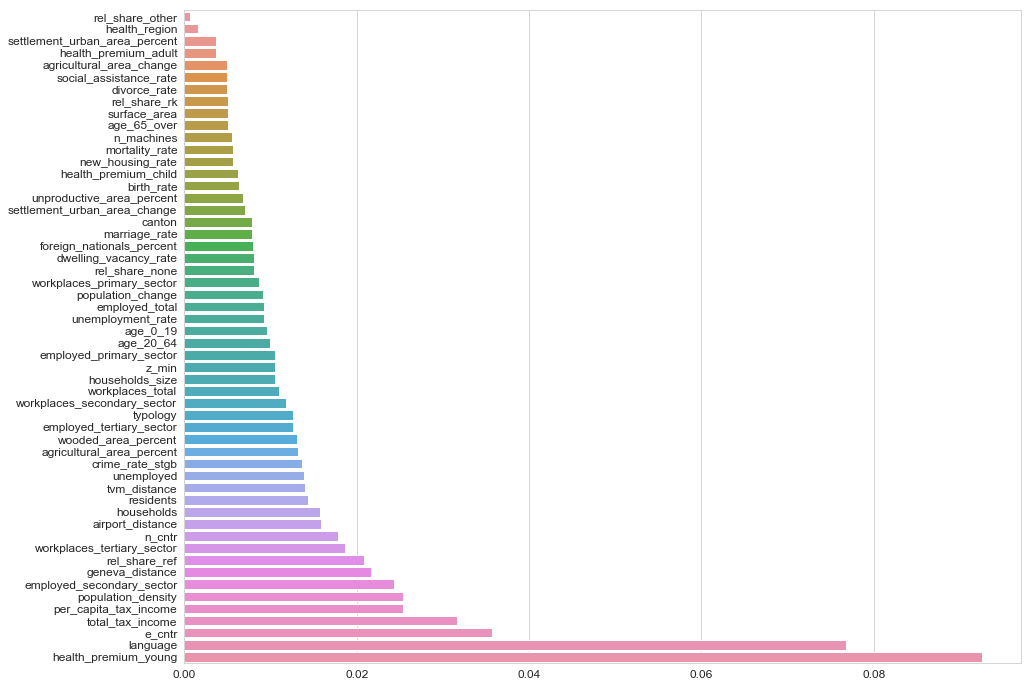

In [18]:
sns.set_style('whitegrid')
plt.figure(figsize = (15,12))
bp = sns.barplot(x=importances_sorted, y=cols_sorted)
bp.tick_params(labelsize="large")

In [19]:
def remove_all(l, r):
    # return list of all elements in list l that are not in list r
    return [i for i in l if not i in r]

In [20]:
reduced_features = remove_all(df.columns,
                              ["po_value",
                               "health_premium_child", "health_premium_adult", # MAE = 0.151
                               "households", "employed_total", "employed_secondary_sector", "employed_tertiary_sector",
                               "workplaces_total", "workplaces_secondary_sector", "workplaces_tertiary_sector",
                               "total_tax_income", "n_machines", # MAE = 0.149
                               "geneva_distance", # MAE = 0.152
                               # "rel_share_other", "rel_share_rk",
                              ])

X_train_red = df_train[reduced_features].values
X_test_red = df_test[reduced_features].values

categorical_features_red = set(categorical_features).intersection(set(reduced_features))
skewed_features_red = set(skewed_features).intersection(set(reduced_features))
unskewed_features_red = set(unskewed_features).intersection(set(reduced_features))

print("categorical_features_red = {} ({})".format(categorical_features_red, len(categorical_features_red)))
print("skewed_features_red = {} ({})".format(skewed_features_red, len(skewed_features_red)))
print("unskewed_features_red = {} ({})".format(unskewed_features_red, len(unskewed_features_red)))

categorical_idxs_red = cols_idxs(df[reduced_features], categorical_features_red)
skewed_idxs_red = cols_idxs(df[reduced_features], skewed_features_red)
unskewed_idxs_red = cols_idxs(df[reduced_features], unskewed_features_red)

print("categorical_idxs_red = {} ({})".format(categorical_idxs_red, len(categorical_idxs_red)))
print("skewed_idxs_red = {} ({})".format(skewed_idxs_red, len(skewed_idxs_red)))
print("unskewed_idxs_red = {} ({})".format(unskewed_idxs_red, len(unskewed_idxs_red)))

categorical_features_red = {'typology', 'canton', 'health_region', 'language'} (4)
skewed_features_red = {'agricultural_area_change', 'surface_area', 'new_housing_rate', 'population_density', 'residents', 'per_capita_tax_income', 'tvm_distance', 'workplaces_primary_sector', 'employed_primary_sector', 'unproductive_area_percent'} (10)
unskewed_features_red = {'wooded_area_percent', 'airport_distance', 'rel_share_rk', 'social_assistance_rate', 'n_cntr', 'population_change', 'agricultural_area_percent', 'age_65_over', 'settlement_urban_area_change', 'unemployment_rate', 'crime_rate_stgb', 'dwelling_vacancy_rate', 'health_premium_young', 'age_20_64', 'marriage_rate', 'unemployed', 'birth_rate', 'households_size', 'e_cntr', 'rel_share_none', 'foreign_nationals_percent', 'rel_share_other', 'divorce_rate', 'z_min', 'age_0_19', 'mortality_rate', 'rel_share_ref', 'settlement_urban_area_percent'} (28)
categorical_idxs_red = [36, 25, 26, 24] (4)
skewed_idxs_red = [16, 12, 22, 2, 0, 32, 40, 20, 19

In [21]:
preprocessor_red = make_column_transformer(
    (OneHotEncoder(dtype=np.float64), categorical_idxs_red),
    remainder = "passthrough"
)
# using best parameters from grid search above
gtbr_red = make_pipeline(preprocessor_red,
                         GradientBoostingRegressor(random_state=0, learning_rate=0.10, n_estimators=700,
                                                   max_depth=3, min_samples_split=7))
gtbr_red.fit(X_train_red, y_train)
importances_red = permutation_importance(gtbr_red, X_train_red, y_train, scoring='neg_mean_absolute_error',
                                         n_repeats=10, n_jobs=12, random_state=0)
gtbr_red_test_pred = gtbr_red.predict(X_test_red)
gtbr_red_test_mae = mean_absolute_error(y_test, gtbr_red_test_pred)
gtbr_red_test_r2 = r2_score(y_test, gtbr_red_test_pred)
print("On test data:")
print("Tuned GTBR (red.) MAE = {:.3f}".format(gtbr_red_test_mae))
print("Tuned GTBR (red.) R^2 = {:.3f}".format(gtbr_red_test_r2))

On test data:
Tuned GTBR (red.) MAE = 0.155
Tuned GTBR (red.) R^2 = 0.741


In [22]:
perm_sorted_idx_red = importances_red["importances_mean"].argsort()
importances_sorted_red = importances_red["importances_mean"][perm_sorted_idx_red]
cols_sorted_red = df_train[reduced_features].columns[perm_sorted_idx_red]

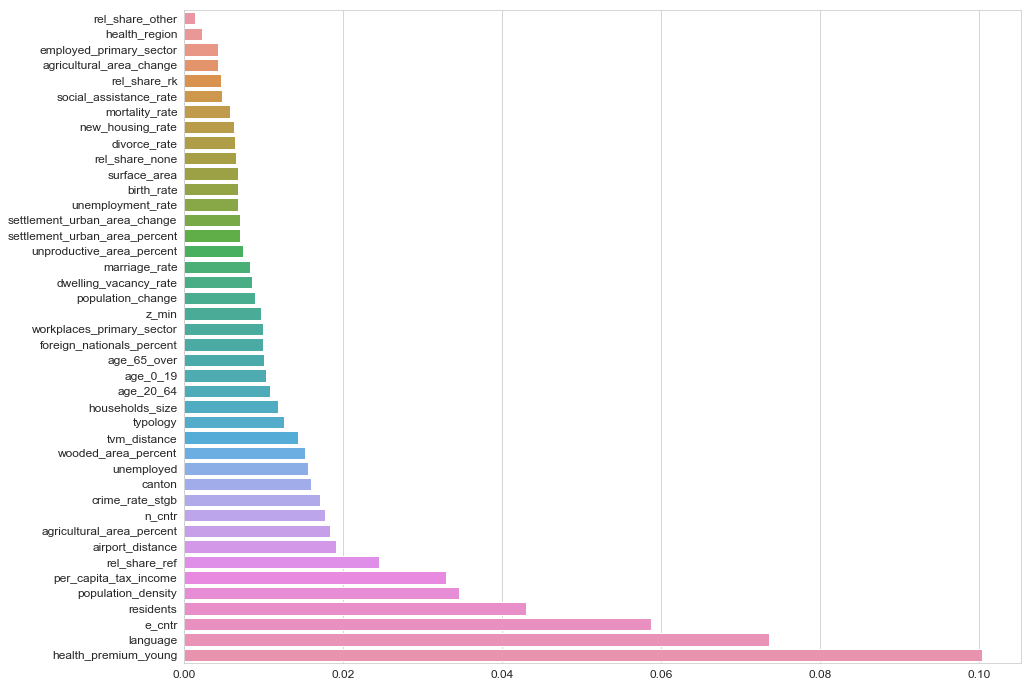

In [23]:
plt.figure(figsize = (15,12))
bp_red = sns.barplot(x=importances_sorted_red, y=cols_sorted_red)
bp_red.tick_params(labelsize="large")